In [21]:
import os, re, shutil, json, time, math
import jieba, numpy
import string, gensim
import threading
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib as plt
from gensim.models.doc2vec import Doc2Vec
from collections import Counter
from tqdm import tqdm
from sklearn import metrics

In [7]:
def extract_jfull(filename: str):
    with open(os.path.join(dirpath + '/drug_case', filename), "r", encoding = 'UTF-8') as f:
        data = json.load(f)['JFULL']
        data = data.replace(' ', '').replace('　', '')
    target0 = data.find('主文\r\n')
    # 如果案字帶有秩的，代表為社會秩序維護法的案子，並不在我們的管理範圍內
    if "秩" in filename: 
        return ""
    
    # 如果 JFULL 找不到主文，那就代表是 pdf 檔案
    # 暫定不處置
    if target0 != -1:
        target1 = []
        if data.find('事實及理由\r\n') != -1:
            target1.append(data.find('事實及理由\r\n', target0))
        if data.find('犯罪事實\r\n') != -1:
            target1.append(data.find('犯罪事實\r\n', target0))
        if data.find('理由\r\n') != -1:
            target1.append(data.find('理由\r\n', target0))
        if data.find('事實\r\n') != -1:
            target1.append(data.find('事實\r\n', target0))
        if data.find('中華民國') != -1:
            target1.append(data.find('中華民國', target0))
        target1 = min(target1)

        data = data[target1:].replace('\r\n', '')
        split_data = re.split(r'[，。「」（）『』【】；：、]', data)
        return (data, split_data)
    else:
        return ""

In [8]:
vector = ['第4條第1項', '第4條第2項', '第4條第3項', '第4條第4項', '第4條第5項', '第4條第6項', '第5條第1項', '第5條第2項', '第5條第3項', '第6條第2項', '第6條第3項', '第6條第4項', '第6條第5項', '第8條第1項', '第8條第2項', '第8條第3項', '第8條第4項', '第8條第5項', '第8條第6項', '第9條第1項', '第9條第2項', '第9條第3項', '第10條第1項', '第10條第2項', '第11條第1項', '第11條第2項', '第11條第3項', '第11條第4項', '第11條第5項', '第11條第6項', '第11條第7項', '第12條第2項', '第13條第2項', '第14條第2項', '第14條第3項', '第14條第4項', '第17條第1項', '第17條第2項', '第17條第3項']

def lawcode_preprocessing(filename, result_str_seq):
    return_list = []
    location1, location2 = 0, 0
    result_lawcode = ''
    
    #若原來字串第一個為第X條第X項，則截取第X條的部分
    if len(result_str_seq[0]) > 5:
        location1 = result_str_seq[0].find('第')
        location2 = result_str_seq[0].find('第', location1)
        # print(result_str_seq[0][location1: location2])
        result_lawcode = result_str_seq[0][location1: location2]
        
    for idx in range(len(result_str_seq)):
        # 如果切割出來的字串長度超過 7 就砍到剩下 7 
        # 之後看到項就截取到項，否則就看有沒有條
        result_str = result_str_seq[idx]
        if len(result_str) > 7: result_str = result_str[:7]
        if "項" in result_str: result_str = result_str[: result_str.find('項') + 1]
        else: result_str = result_str[: result_str.find('條') + 1]

        # TODO: 單純「第X項」的沒有處理好
        if len(result_str) > 5 and result_str[0] == '第' and result_str[-1] == '項':
            result_str = result_lawcode + result_str
        for j in ["第" + str(k) + "條" for k in range(4, 18)]:
            if j in result_str:
                return_list.append(result_str)
    #print(i, return_list)
    return return_list

def lawcode_vectoring(text):
    textloc2 = 0
    all_result_str_seq = []
    text_vector = [0] * 39
    
    while 1:
        textloc1 = text.find('毒品危害防制條例第', textloc2)
        if textloc1 == -1: break
        tmp = text[textloc1: textloc1 + 30]
        if "刑法" in tmp: tmp = tmp[: tmp.find('刑法')]
        textloc2 = max(tmp.rfind('項'), (tmp.rfind('項') == -1) * tmp.rfind('條'))
        if textloc2 == -1: continue
        result_str_seq = text[textloc1 + 8: textloc1 + textloc2 + 1].split('、')
        
        result_str_seq = lawcode_preprocessing(i, result_str_seq)
        all_result_str_seq.extend(result_str_seq)
        all_result_str_seq = list(set(all_result_str_seq) & set(vector))
        
        # counting the word freq and return freq word vector
        for result_str in all_result_str_seq:
            text_vector[vector.index(result_str)] += 1
        textloc2 = textloc1 + textloc2 + 1
        
    return text_vector

In [9]:
desktop = os.environ['USERPROFILE'] + '/Desktop'
dirpath = desktop + '/Drug_NLP'

model = Doc2Vec.load(dirpath + "/drug_model.bin")
tmp = open(dirpath + '/label.txt', 'r', encoding = 'utf-8').readlines()
# check text now is in the text file of project directory
check_text = [i[:-1] for i in open(dirpath + '/drug_dict.txt', 'r', encoding = 'utf-8').readlines()]

label = {}
train, train_label = [], []

for i in tqdm(tmp):
    filename, sencnt = i.split()
    label[filename] = sencnt
    beh = [0] * len(check_text)
    
    # text preprocessing
    text, split_text = extract_jfull(filename)
    text = text.replace('第1、2項', '第1項、第2項').replace('第3、4項', '第3項、第4項') \
        .replace('條條', '條').replace('第第', '第').replace('２', '2')
    for j in ["條" + str(k) + "項" for k in range(7)]:
        text = text.replace(j, j[0] + "第" + j[1:])
        
    all_result_str_seq = lawcode_vectoring(text)
        
    for ii in range(len(check_text)):
        beh[ii] = text.count(check_text[ii])

    # loss comparison: 
    ## keyword + lawcode: 400-500
    ## only doc2vec: 266
    ## doc2vec + keyword + lawcode: 173
    ## doc2vec + keyword: 210
    text_vec = np.array(model.infer_vector(split_text).tolist() + beh + all_result_str_seq)
   
    train.append(text_vec)
    train_label.append(sencnt)

100%|███████████████████████████████████████████████████████████████████████████| 23112/23112 [00:38<00:00, 606.34it/s]


In [10]:
print(len(train), len(train_label))

23112 23112


In [11]:
train = np.array(train)
train_label = np.array(train_label)
print(train.shape, train_label.shape)

(23112, 420) (23112,)


## Create Dataset

In [12]:
import torch
from torch.utils.data import Dataset

class DrugDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.float)
            self.label = torch.FloatTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [13]:
VAL_RATIO = 0.1

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (20800, 420)
Size of validation set: (2312, 420)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [14]:
BATCH_SIZE = 512

from torch.utils.data import DataLoader

train_set = DrugDataset(train_x, train_y)
val_set = DrugDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\terry\AppData\Local\Temp/ipykernel_10308/604575324.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [15]:
import torch as t
import torch.nn as nn

class NN(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NN, self).__init__()

        self.net = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x)

## Training

In [16]:
#check device
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda


Feel free to change the training parameters here.

In [12]:
# debug parameter
show_taskbar = False
show_cycle = 10

model = NN(train.shape[1]).to(device)
model.device = device
if os.path.exists('best_weight.pth'):
    try:
        model.load_state_dict(torch.load('best_weight.pth'))
    except: 
        print('The model weight does not exist!')

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-5, weight_decay = 1e-5)

# The number of training epochs.
n_epochs = 1000
best_loss = 1000.0
train_loss_record = []
valid_loss_record = []

for epoch in range(n_epochs):
    model.train()
    train_loss = []
    train_accs = []
    
    if show_taskbar == True:
        train_loader = tqdm(train_loader)
        val_loader = tqdm(val_loader)
    
    # Iterate the training set by batches.
    for batch in train_loader:
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(torch.squeeze(logits), labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        # Record the loss and accuracy.
        train_loss.append(loss.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_loss_record.append(train_loss)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    valid_loss = []

    # Iterate the validation set by batches.
    for batch in val_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
        loss = criterion(torch.squeeze(logits), labels.to(device))
        valid_loss.append(loss.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_loss_record.append(valid_loss)
    
    if valid_loss < best_loss:
        print("best loss updated!")
        print(valid_loss, best_loss)
        best_model = model
        best_loss = valid_loss
        torch.save(model.state_dict(), "best_weight.pth")
        
    if epoch % show_cycle == 0:
        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}")
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}")

The model weight does not exist!
best loss updated!
320.3178192138672 1000.0
[ Train | 001/1000 ] loss = 605.89189
[ Valid | 001/1000 ] loss = 320.31782
best loss updated!
298.8758262634277 320.3178192138672
best loss updated!
291.29490394592284 298.8758262634277
best loss updated!
288.2724349975586 291.29490394592284
best loss updated!
281.29564208984374 288.2724349975586
best loss updated!
278.5270706176758 281.29564208984374
best loss updated!
273.063391494751 278.5270706176758
[ Train | 011/1000 ] loss = 212.45895
[ Valid | 011/1000 ] loss = 311.11584
best loss updated!
272.6367637634277 273.063391494751
best loss updated!
265.19508666992186 272.6367637634277
best loss updated!
263.9089714050293 265.19508666992186
[ Train | 021/1000 ] loss = 140.89330
[ Valid | 021/1000 ] loss = 263.90897
best loss updated!
260.4142841339111 263.9089714050293
[ Train | 031/1000 ] loss = 111.80512
[ Valid | 031/1000 ] loss = 332.27286
best loss updated!
248.56989994049073 260.4142841339111
[ Train |

In [19]:
print(best_loss)

205.19659805297852


## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [17]:
# create testing dataset
test_set = DrugDataset(val_x, val_y)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\terry\AppData\Local\Temp/ipykernel_10308/604575324.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


Make prediction and output the result.

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 113.54it/s]

answers:  [6, 6, 8, 7, 6, 2, 4, 6, 6, 6, 7, 6, 6, 6, 5, 5, 5, 6, 6, 4, 4, 12, 20, 5, 5, 8, 7, 3, 3, 5, 7, 8, 0, 3, 4, 4, 6, 3, 2, 3, 2, 12, 6, 0, 7, 9, 3, 6, 4, 3, 4, 5, 7, 6, 4, 5, 6, 5, 6, 3, 0, 5, 8, 3, 6, 18, 6, 6, 4, 0, 0, 3, 6, 3, 3, 4, 3, 4, 4, 6, 7, 6, 3, 2, 1, 6, 6, 1, 3, 11, 2, 7, 2, 5, 6, 2, 6, 1, 2, 2, 5, 2, 5, 6, 2, 2, 6, 1, 2, 6, 6, 4, 2, 5, 5, 4, 4, 2, 6, 6, 5, 2, 6, 6, 3, 6, 4, 6, 7, 2, 0, 6, 0, 2, 5, 5, 2, 6, 5, 2, 6, 3, 3, 6, 2, 2, 6, 6, 6, 3, 0, 6, 6, 6, 6, 3, 2, 6, 1, 6, 5, 2, 4, 6, 6, 3, 4, 4, 4, 5, 5, 4, 4, 4, 4, 1, 3, 5, 2, 3, 18, 6, 1, 4, 2, 2, 4, 6, 3, 6, 5, 3, 6, 4, 4, 5, 6, 6, 4, 5, 4, 3, 5, 5, 5, 6, 3, 1, 1, 6, 6, 4, 3, 2, 2, 4, 3, 4, 2, 6, 3, 3, 3, 6, 6, 3, 4, 6, 6, 2, 6, 2, 2, 2, 3, 4, 2, 2, 3, 6, 2, 6, 4, 0, 19, 2, 4, 2, 5, 6, 6, 3, 3, 2, 6, 3, 3, 3, 3, 3, 2, 3, 1, 2, 6, 3, 3, 2, 4, 3, 1, 1, 3, 3, 3, 3, 3, 4, 5, 5, 3, 0, 4, 6, 4, 2, 2, 6, 1, 0, 4, 2, 6, 6, 6, 6, 6, 3, 2, 4, 3, 4, 3, 5, 4, 4, 6, 0, 0, 6, 0, 3, 4, 0, 2, 4, 2, 2, 6, 2, 0, 15, 15, 6, 16, 6, 7

<AxesSubplot:>

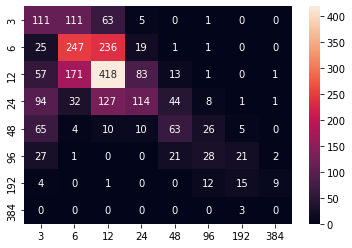

In [26]:
model = NN(train.shape[1]).to(device)
if os.path.exists('best_weight.pth'):
    try:
        model.load_state_dict(torch.load('best_weight.pth'))
    except: 
        print('The model weight does not exist!')

predict = []
answers = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
            guess = list(map(int, torch.squeeze(logits.cpu()).numpy().tolist()))
            predict.extend(guess)
            answer = list(map(int, labels.to(device).tolist()))
            answers.extend(answer)
#show the partial result
print("answers: ", answers)    
print("predict: ", predict)

predict_group = list(map(lambda x: math.floor(math.log2(math.ceil(x))) if x > 0 else 0, predict))
answers_group = list(map(lambda x: math.floor(math.log2(math.ceil(x))) if x > 0 else 0, answers))
df_cm = metrics.confusion_matrix(predict_group, answers_group)
df_cm = pd.DataFrame(df_cm, index = [i for i in [3, 6, 12, 24, 48, 96, 192, 384]], columns = [i for i in [3, 6, 12, 24, 48, 96, 192, 384]])
plt.figure.Figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")

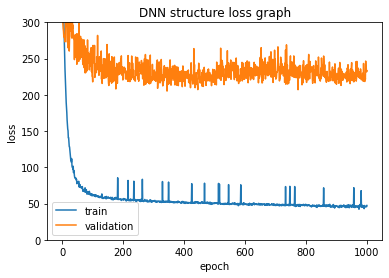

In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x = train_loss_record
y = valid_loss_record
epoch = [i for i in range(1, n_epochs + 1)]

plt.ylim([0, 300])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('DNN structure loss graph')
plt.plot(epoch, x, label = 'train')
plt.plot(epoch, y, label = 'validation')
plt.legend()
plt.show()

In [27]:
print(len([6, 6, 8, 7, 6, 2, 4, 6, 6, 6, 7, 6, 6, 6, 5, 5, 5, 6, 6, 4, 4, 12, 20, 5, 5, 8, 7, 3, 3, 5, 7, 8, 0, 3, 4, 4, 6, 3, 2, 3, 2, 12, 6, 0, 7, 9, 3, 6, 4, 3, 4, 5, 7, 6, 4, 5, 6, 5, 6, 3, 0, 5, 8, 3, 6, 18, 6, 6, 4, 0, 0, 3, 6, 3, 3, 4, 3, 4, 4, 6, 7, 6, 3, 2, 1, 6, 6, 1, 3, 11, 2, 7, 2, 5, 6, 2, 6, 1, 2, 2, 5, 2, 5, 6, 2, 2, 6, 1, 2, 6, 6, 4, 2, 5, 5, 4, 4, 2, 6, 6, 5, 2, 6, 6, 3, 6, 4, 6, 7, 2, 0, 6, 0, 2, 5, 5, 2, 6, 5, 2, 6, 3, 3, 6, 2, 2, 6, 6, 6, 3, 0, 6, 6, 6, 6, 3, 2, 6, 1, 6, 5, 2, 4, 6, 6, 3, 4, 4, 4, 5, 5, 4, 4, 4, 4, 1, 3, 5, 2, 3, 18, 6, 1, 4, 2, 2, 4, 6, 3, 6, 5, 3, 6, 4, 4, 5, 6, 6, 4, 5, 4, 3, 5, 5, 5, 6, 3, 1, 1, 6, 6, 4, 3, 2, 2, 4, 3, 4, 2, 6, 3, 3, 3, 6, 6, 3, 4, 6, 6, 2, 6, 2, 2, 2, 3, 4, 2, 2, 3, 6, 2, 6, 4, 0, 19, 2, 4, 2, 5, 6, 6, 3, 3, 2, 6, 3, 3, 3, 3, 3, 2, 3, 1, 2, 6, 3, 3, 2, 4, 3, 1, 1, 3, 3, 3, 3, 3, 4, 5, 5, 3, 0, 4, 6, 4, 2, 2, 6, 1, 0, 4, 2, 6, 6, 6, 6, 6, 3, 2, 4, 3, 4, 3, 5, 4, 4, 6, 0, 0, 6, 0, 3, 4, 0, 2, 4, 2, 2, 6, 2, 0, 15, 15, 6, 16, 6, 7, 6, 7, 9, 3, 6, 6, 7, 4, 24, 8, 3, 5, 5, 6, 7, 8, 8, 2, 8, 3, 9, 8, 6, 10, 4, 6, 9, 6, 6, 6, 6, 5, 6, 8, 7, 5, 5, 16, 8, 8, 7, 3, 6, 12, 11, 6, 8, 16, 8, 8, 3, 7, 3, 7, 6, 6, 9, 0, 10, 28, 3, 16, 6, 8, 7, 6, 6, 14, 16, 4, 30, 9, 6, 12, 6, 8, 6, 7, 6, 3, 10, 4, 5, 22, 6, 0, 10, 32, 6, 8, 6, 30, 6, 6, 6, 6, 12, 0, 4, 6, 6, 6, 6, 0, 6, 6, 4, 18, 14, 4, 6, 6, 6, 8, 6, 0, 6, 11, 0, 6, 4, 9, 6, 6, 18, 6, 12, 26, 10, 6, 3, 3, 4, 5, 7, 8, 6, 6, 4, 7, 6, 8, 11, 5, 6, 26, 8, 12, 10, 12, 5, 9, 5, 5, 6, 5, 7, 8, 2, 6, 9, 9, 6, 5, 6, 8, 16, 8, 4, 6, 3, 3, 6, 9, 5, 5, 7, 6, 11, 4, 3, 6, 7, 5, 5, 6, 4, 4, 6, 5, 6, 3, 7, 11, 6, 6, 0, 42, 6, 9, 9, 7, 9, 8, 9, 11, 11, 10, 20, 6, 5, 8, 6, 6, 6, 9, 5, 6, 9, 8, 2, 2, 9, 11, 8, 4, 7, 8, 7, 5, 7, 5, 12, 9, 9, 10, 6, 6, 3, 8, 8, 9, 11, 7, 8, 7, 6, 7, 5, 3, 4, 20, 6, 11, 10, 7, 5, 10, 8, 10, 6, 8, 3, 8, 5, 6, 5, 3, 8, 6, 5, 10, 9, 6, 6, 9, 6, 6, 6, 3, 12, 6, 9, 4, 6, 3, 6, 6, 6, 7, 5, 6, 6, 6, 6, 30, 3, 6, 14, 10, 6, 5, 3, 4, 7, 8, 7, 9, 6, 12, 9, 7, 8, 6, 4, 4, 6, 5, 9, 10, 7, 0, 6, 7, 5, 6, 9, 14, 14, 5, 8, 4, 7, 8, 8, 17, 17, 6, 26, 20, 20, 20, 3, 3, 0, 26, 4, 0, 7, 8, 4, 0, 0, 8, 2, 8, 0, 2, 8, 0, 2, 4, 3, 2, 4, 3, 3, 3, 0, 2, 4, 2, 2, 3, 6, 4, 2, 0, 2, 2, 2, 2, 2, 3, 3, 4, 2, 2, 5, 4, 2, 4, 4, 2, 4, 4, 4, 5, 2, 2, 2, 3, 2, 4, 4, 0, 2, 5, 4, 3, 6, 4, 2, 2, 2, 2, 2, 6, 2, 0, 5, 2, 2, 5, 2, 2, 5, 4, 0, 5, 3, 6, 0, 4, 6, 2, 2, 2, 6, 3, 2, 2, 2, 3, 3, 5, 2, 5, 4, 4, 5, 5, 5, 4, 4, 0, 5, 2, 4, 3, 2, 4, 2, 2, 6, 5, 5, 3, 5, 2, 6, 3, 3, 4, 4, 3, 3, 2, 4, 2, 4, 6, 3, 4, 2, 2, 4, 4, 6, 5, 3, 2, 5, 2, 2, 3, 6, 2, 0, 3, 4, 4, 3, 6, 2, 6, 6, 2, 5, 0, 4, 5, 4, 2, 2, 2, 5, 3, 6, 3, 4, 3, 5, 4, 2, 3, 6, 0, 6, 5, 4, 2, 5, 4, 5, 4, 3, 4, 3, 3, 3, 2, 2, 3, 2, 4, 2, 3, 0, 4, 2, 2, 5, 3, 3, 3, 2, 4, 2, 0, 3, 0, 4, 2, 5, 5, 6, 3, 2, 2, 0, 3, 3, 3, 4, 3, 1, 4, 2, 3, 6, 4, 2, 3, 2, 4, 3, 6, 2, 2, 5, 3, 2, 4, 2, 2, 3, 3, 2, 0, 3, 4, 2, 4, 2, 2, 5, 4, 6, 6, 6, 5, 4, 3, 2, 4, 2, 5, 2, 3, 4, 4, 2, 6, 4, 2, 2, 2, 2, 5, 6, 4, 3, 2, 4, 0, 2, 3, 3, 3, 6, 2, 0, 3, 4, 2, 2, 6, 3, 6, 2, 3, 2, 4, 2, 2, 2, 2, 4, 2, 4, 4, 3, 3, 0, 2, 2, 3, 2, 2, 3, 5, 3, 2, 5, 2, 2, 0, 6, 0, 6, 4, 5, 5, 3, 5, 2, 2, 6, 4, 5, 2, 2, 5, 2, 2, 3, 5, 2, 3, 4, 2, 6, 2, 5, 0, 2, 5, 6, 3, 3, 3, 3, 6, 2, 3, 2, 3, 2, 2, 3, 4, 0, 3, 4, 2, 6, 2, 2, 2, 2, 4, 2, 4, 2, 6, 4, 2, 2, 2, 3, 3, 6, 4, 2, 3, 3, 2, 6, 3, 2, 6, 5, 3, 0, 6, 3, 2, 2, 2, 4, 2, 3, 2, 4, 4, 6, 3, 6, 3, 3, 2, 4, 2, 5, 6, 4, 2, 6, 3, 3, 3, 5, 2, 2, 3, 2, 0, 4, 4, 2, 0, 2, 6, 2, 4, 6, 2, 4, 4, 2, 6, 2, 6, 2, 4, 5, 3, 5, 2, 4, 2, 2, 5, 4, 5, 6, 2, 4, 2, 5, 5, 3, 3, 5, 5, 4, 2, 5, 4, 2, 6, 6, 5, 2, 3, 2, 4, 3, 4, 2, 6, 2, 2, 2, 4, 6, 4, 4, 4, 3, 4, 6, 5, 3, 2, 2, 6, 6, 0, 6, 2, 5, 4, 6, 2, 4, 5, 6, 3, 5, 2, 4, 2, 4, 6, 5, 4, 4, 5, 3, 3, 4, 2, 3, 6, 6, 3, 5, 3, 3, 2, 2, 6, 6, 2, 2, 6, 6, 3, 5, 4, 2, 3, 4, 4, 2, 5, 4, 3, 6, 3, 2, 0, 6, 3, 3, 3, 4, 3, 3, 2, 2, 3, 2, 0, 4, 2, 3, 6, 2, 4, 6, 3, 3, 1, 2, 5, 2, 3, 2, 2, 4, 4, 6, 4, 6, 6, 3, 4, 3, 2, 6, 6, 3, 2, 5, 2, 3, 3, 4, 3, 4, 4, 2, 2, 3, 6, 5, 4, 5, 4, 0, 60, 52, 3, 6, 0, 4, 4, 4, 3, 0, 8, 0, 204, 24, 34, 24, 34, 3, 21, 24, 36, 24, 6, 24, 48, 26, 42, 16, 0, 21, 22, 44, 0, 42, 20, 24, 58, 22, 48, 54, 24, 60, 21, 46, 114, 23, 120, 204, 20, 66, 21, 22, 42, 21, 48, 46, 30, 48, 48, 82, 22, 6, 22, 24, 12, 54, 8, 8, 36, 22, 44, 24, 22, 22, 21, 22, 182, 0, 54, 44, 42, 2, 20, 52, 22, 24, 12, 42, 22, 24, 7, 30, 24, 14, 22, 112, 0, 72, 20, 60, 64, 26, 24, 21, 48, 27, 22, 48, 24, 24, 54, 22, 24, 90, 24, 60, 26, 24, 30, 24, 6, 22, 22, 18, 4, 0, 7, 21, 24, 122, 72, 18, 90, 28, 46, 22, 24, 24, 8, 120, 66, 24, 45, 24, 20, 24, 22, 21, 5, 192, 46, 24, 0, 24, 58, 32, 21, 43, 28, 46, 24, 24, 36, 28, 138, 19, 30, 44, 132, 44, 30, 136, 0, 24, 48, 43, 25, 90, 108, 182, 78, 74, 0, 0, 0, 43, 0, 6, 6, 6, 5, 4, 5, 5, 6, 5, 3, 4, 3, 46, 6, 10, 3, 0, 10, 8, 3, 14, 7, 4, 2, 8, 5, 6, 4, 3, 5, 6, 3, 6, 0, 2, 2, 4, 4, 5, 6, 14, 2, 3, 5, 5, 4, 6, 6, 3, 4, 4, 6, 6, 3, 6, 2, 5, 6, 5, 4, 4, 0, 0, 74, 23, 0, 0, 6, 90, 8, 0, 8, 74, 46, 0, 190, 0, 0, 13, 74, 11, 53, 24, 7, 8, 0, 53, 21, 9, 36, 10, 27, 113, 0, 3, 190, 9, 24, 0, 10, 53, 24, 102, 42, 96, 48, 7, 43, 27, 54, 11, 6, 26, 54, 2, 34, 10, 38, 10, 7, 12, 8, 7, 54, 0, 0, 98, 52, 93, 8, 11, 10, 9, 22, 8, 5, 9, 8, 9, 10, 9, 23, 14, 99, 190, 7, 24, 4, 2, 3, 5, 6, 2, 5, 6, 6, 2, 6, 3, 5, 5, 3, 5, 5, 3, 2, 6, 5, 5, 5, 3, 6, 5, 3, 3, 5, 0, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 2, 6, 3, 3, 6, 3, 3, 3, 5, 5, 8, 3, 5, 5, 5, 2, 8, 46, 7, 7, 7, 7, 7, 4, 6, 6, 4, 6, 6, 6, 6, 3, 7, 8, 0, 4, 3, 6, 5, 6, 6, 3, 4, 3, 12, 6, 6, 4, 4, 3, 6, 7, 7, 7, 3, 0, 3, 0, 0, 0, 6, 2, 0, 3, 7, 6, 6, 5, 7, 3, 5, 5, 3, 4, 5, 4, 3, 5, 4, 2, 4, 3, 6, 2, 2, 3, 3, 3, 3, 3, 6, 5, 4, 3, 2, 2, 2, 5, 6, 3, 6, 6, 3, 6, 6, 3, 3, 4, 6, 4, 6, 6, 5, 6, 6, 3, 2, 3, 3, 3, 3, 4, 9, 0, 6, 2, 4, 5, 5, 2, 6, 6, 2, 3, 3, 3, 6, 4, 6, 5, 5, 4, 6, 5, 5, 3, 4, 4, 6, 6, 6, 3, 5, 6, 5, 3, 5, 4, 4, 4, 4, 3, 6, 4, 3, 4, 3, 3, 2, 4, 0, 4, 3, 5, 4, 0, 5, 5, 6, 4, 4, 6, 4, 4, 5, 6, 5, 2, 4, 5, 4, 6, 5, 6, 3, 4, 6, 6, 2, 5, 38, 9, 10, 93, 9, 0, 8, 6, 8, 12, 22, 114, 48, 7, 7, 0, 22, 8, 7, 102, 126, 7, 10, 10, 10, 7, 10, 9, 20, 190, 72, 11, 3, 9, 6, 4, 9, 58, 18, 9, 6, 20, 10, 24, 0, 18, 8, 7, 44, 48, 8, 7, 24, 52, 50, 18, 9, 0, 45, 8, 11, 48, 14, 18, 64, 13, 7, 30, 100, 8, 8, 11, 108, 108, 5, 6, 7, 10, 6, 8, 50, 10, 8, 9, 10, 24, 7, 23, 12, 11, 0, 5, 8, 6, 8, 8, 9, 9, 7, 10, 42, 6, 24, 8, 96, 0, 27, 2, 86, 9, 7, 9, 12, 10, 11, 10, 7, 78, 8, 8, 12, 8, 8, 6, 3, 5, 78, 12, 197, 0, 24, 118, 9, 24, 0, 0, 0, 10, 64, 0, 54, 0, 11, 8, 20, 75, 0, 8, 0, 30, 10, 0, 0, 0, 86, 4, 92, 22, 7, 46, 0, 48, 11, 3, 9, 6, 9, 6, 8, 12, 8, 9, 24, 10, 6, 7, 6, 8, 3, 9, 0, 6, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

2312
